In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainerCallback, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset, load_dataset
from copy import deepcopy

os.environ["WANDB_DISABLED"] = "true"
# os.environ["TOKENIZERS_PARALLELISM"] = "false"

RANDOM_STATE = 42

In [2]:
id2label = {0: "CORRECT", 1: "BUGGY"}
label2id = {"CORRECT": 0, "BUGGY": 1}

In [5]:
tokenizer = AutoTokenizer.from_pretrained('dipudl/codet5-base')
# model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased',
#                                                            num_labels=2,
#                                                            id2label=id2label,
#                                                            label2id=label2id)
model = AutoModelForSequenceClassification.from_pretrained('dipudl/function-args-swap-bug-distilbert-model',
                                                           num_labels=2,
                                                           id2label=id2label,
                                                           label2id=label2id)

Downloading:   0%|          | 0.00/727 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

In [6]:
!pip install huggingface_hub
!python -c "from huggingface_hub.hf_api import HfFolder; HfFolder.save_token('XXXXXX')"

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


-----
## Load Dataset
-----

In [46]:
train_df = pd.read_csv("/kaggle/input/func-args-swap-dataset/func_args_dataset_filtered_train.csv", sep="\t")
test_df = pd.read_csv("/kaggle/input/func-args-swap-dataset/func_args_dataset_filtered_test.csv", sep="\t")

In [47]:
train_df.sample(10)

,file,function_name,arg1,arg2,arg_type,param1,param2,labels
376907,cleaned/iaxproxy/main/channel.c,clone_variables,clonechan,original,struct ast_channel *,original,clonechan,1
174932,cleaned/jfsw/src/ripper.c,PickJumpMaxSpeed,SpriteNum,-400,short,SpriteNum,max_speed,0
418981,cleaned/dd-wrt/src/router/iproute2/ip/iproute.c,matches,*argv,cached,char *,NaN,NaN,0
416888,cleaned/vlc/modules/access/http.c,strcasecmp,psz,authentication-info,const char *,NaN,NaN,0
218394,cleaned/fence-virt/server/tcp.c,strcasecmp,ipv4,value,const char *,__s1,__s2,1
387021,cleaned/tos-sfsu-fall2012/kernel/shell.c,is_command,vga,command,char *,s1,s2,1
132009,cleaned/reconos/core/ecos/ecos-patched/ecos/pa...,strcmp,argv[t],-N,const char *,__s1,__s2,1
135329,cleaned/linux/drivers/hwmon/pmbus/lm25066.c,DIV_ROUND_CLOSEST,ret*70,453,int,NaN,NaN,0
359428,cleaned/libav/libavformat/rtmpproto.c,strstr,desc,?reason=authfailed,const char *,__haystack,__needle,0
339545,cleaned/wterm/src/vttest/esc.c,brc,'A',pn,int,pn,c,1


In [48]:
test_df.sample(5)

,file,function_name,arg1,arg2,arg_type,param1,param2,labels
36555,cleaned/unvanquished/src/libs/glsl-optimizer/s...,ralloc_steal,(yyval.string_list),(yyvsp[(3)-(3)].str),<dependent type>,NaN,NaN,0
29580,cleaned/cox/CoX/Driver/LCD_Graphic/SSD1298/SSD...,LCD_WriteReg,0x00BB,0x1E,unsigned short,usCmd,usValue,1
16924,cleaned/fvwm/fvwm/style.c,StrEquals,token,Slippery,char *,NaN,NaN,0
21110,cleaned/snippets/c/net/tcp/cracker/client.c,crypt,passwd,pass_attempt,const char *,__key,__salt,1
49806,cleaned/pbrt-v2/src/tools/ply.c,equal_strings,end_header,words[0],char *,NaN,NaN,1


In [49]:
train_df.shape, test_df.shape

((486534, 8), (54060, 8))

In [50]:
train_df.isna().sum()

file                  0
function_name      2216
arg1               3151
arg2               3151
arg_type              0
param1           325066
param2           325024
labels                0
dtype: int64

In [51]:
train_df.dropna(subset=["function_name", "arg1", "arg2"], inplace=True)
train_df.isna().sum()

file                  0
function_name         0
arg1                  0
arg2                  0
arg_type              0
param1           319126
param2           319080
labels                0
dtype: int64

In [52]:
test_df.isna().sum()

file                 0
function_name      216
arg1               371
arg2               371
arg_type             0
param1           36142
param2           36138
labels               0
dtype: int64

In [53]:
test_df.dropna(subset=["function_name", "arg1", "arg2"], inplace=True)
test_df.isna().sum()

file                 0
function_name        0
arg1                 0
arg2                 0
arg_type             0
param1           35466
param2           35462
labels               0
dtype: int64

In [54]:
train_df.shape, test_df.shape

((478038, 8), (53102, 8))

In [16]:
train_df['param1'] = train_df['param1'].fillna(tokenizer.unk_token)
train_df['param2'] = train_df['param2'].fillna(tokenizer.unk_token)
train_df.isna().sum()

file             0
function_name    0
arg1             0
arg2             0
arg_type         0
param1           0
param2           0
labels           0
dtype: int64

In [17]:
test_df['param1'] = test_df['param1'].fillna(tokenizer.unk_token)
test_df['param2'] = test_df['param2'].fillna(tokenizer.unk_token)
train_df.isna().sum()

file             0
function_name    0
arg1             0
arg2             0
arg_type         0
param1           0
param2           0
labels           0
dtype: int64

In [18]:
train_df['full_text'] = train_df['function_name'] + tokenizer.sep_token + train_df['arg1'] + tokenizer.sep_token + train_df['arg2'] + tokenizer.sep_token + train_df['arg_type'] + tokenizer.sep_token + train_df['param1'] + tokenizer.sep_token + train_df['param2']
test_df['full_text'] = test_df['function_name'] + tokenizer.sep_token + test_df['arg1'] + tokenizer.sep_token + test_df['arg2'] + tokenizer.sep_token + test_df['arg_type'] + tokenizer.sep_token + test_df['param1'] + tokenizer.sep_token + test_df['param2']

In [19]:
train_df.drop(['function_name','arg1','arg2','arg_type','param1','param2'], axis=1, inplace=True)
test_df.drop(['function_name','arg1','arg2','arg_type','param1','param2'], axis=1, inplace=True)

In [20]:
train_df.sample(5)

,file,labels,full_text
333323,cleaned/ipxe/src/arch/i386/interface/pxeparent...,1,DBG</s>strerror(rc)</s>PXEDHCP GET_CACHED_INFO...
129700,cleaned/minikonoha/src/module-devel/Bash/Bash.c,0,strcmp</s>receiverClassName</s>SubProc</s>cons...
99602,cleaned/freeswitch/libs/xmlrpc-c/tools/lib/dum...,0,printf</s>'%s'\n</s>printable</s>const char *<...
18811,cleaned/composite/src/components/lib/dietlibc-...,0,"strcmp</s>getenv(""foo"")</s>baz</s>const char *..."
40243,cleaned/asf_mapready/src/asf_meta/distortions.c,1,hypot</s>dy_dlat</s>dx_dlat</s>double</s><unk>...


In [21]:
test_df.sample(5)

,file,labels,full_text
51012,cleaned/gtk-gnutella/src/core/guid.c,0,stable_still_alive_probability</s>gd->create_t...
35673,cleaned/openafs-osd/src/util/ktime.c,0,strcmp</s>tp->key</s>tt->key</s>const char *</...
45978,cleaned/asuswrt-merlin/release/src-rt/linux/li...,1,list_add_tail</s>&p->signal->shared_pending.li...
23533,cleaned/syslog-ng/tests/unit/test_template.c,1,assert_template_format</s>bzorp</s>$FULLHOST</...
53733,cleaned/mvfs/mvfs_utils.c,1,STRCMP</s>hmsuffix</s>hmnm</s>char *</s><unk><...


In [22]:
print(train_df.iloc[10].full_text)
print("-" * 80)
print(tokenizer.tokenize(train_df.iloc[10].full_text))
print("-" * 80)
print(tokenizer(train_df.iloc[10].full_text))

strcmp</s>all</s>cmd</s>const char *</s><unk></s><unk>
--------------------------------------------------------------------------------
['strcmp', '</s>', 'all', '</s>', 'cmd', '</s>', 'const', 'Ġchar', 'Ġ*', '</s>', '<unk>', '</s>', '<unk>']
--------------------------------------------------------------------------------
{'input_ids': [1, 2381, 2, 631, 2, 1310, 2, 964, 628, 366, 2, 3, 2, 3, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [23]:
def tokenize_text(examples):
    return tokenizer(examples["full_text"], truncation=True, max_length=128, padding=True)

In [24]:
train_df, validation_df = train_test_split(train_df, test_size=0.1, random_state=RANDOM_STATE)
train_df.shape, validation_df.shape

((430234, 3), (47804, 3))

In [25]:
train_dataset = Dataset.from_pandas(train_df)
train_dataset

Dataset({
    features: ['file', 'labels', 'full_text', '__index_level_0__'],
    num_rows: 430234
})

In [26]:
validation_dataset = Dataset.from_pandas(validation_df)
validation_dataset

Dataset({
    features: ['file', 'labels', 'full_text', '__index_level_0__'],
    num_rows: 47804
})

In [27]:
test_dataset = Dataset.from_pandas(test_df)
test_dataset

Dataset({
    features: ['file', 'labels', 'full_text', '__index_level_0__'],
    num_rows: 53102
})

-----
## Tokenization
-----

In [28]:
train_dataset = train_dataset.map(tokenize_text, batched=True, remove_columns=["full_text", "__index_level_0__"])
train_dataset

  0%|          | 0/431 [00:00<?, ?ba/s]

Dataset({
    features: ['file', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 430234
})

In [29]:
validation_dataset = validation_dataset.map(tokenize_text, batched=True, remove_columns=["full_text", "__index_level_0__"])
validation_dataset

  0%|          | 0/48 [00:00<?, ?ba/s]

Dataset({
    features: ['file', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 47804
})

In [30]:
test_dataset = test_dataset.map(tokenize_text, batched=True, remove_columns=["full_text", "__index_level_0__"])
test_dataset

  0%|          | 0/54 [00:00<?, ?ba/s]

Dataset({
    features: ['file', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 53102
})

In [44]:
def softmax(x):
    result = np.zeros_like(x)
    
    for i in range(len(x)):
        result[i] = np.exp(x[i]) / np.sum(np.exp(x[i]), axis=0)
    return result

In [31]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    f1 = f1_score(labels, preds)
    return {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1}

-----
## Model Training
-----

In [32]:
# ! rm -rd /kaggle/working/codeT5-DistilBERT-function-swap-bug-model

batch_size = 64
logging_steps = len(train_dataset) // batch_size
output_dir = "codeT5-DistilBERT-function-swap-bug-model"

training_args = TrainingArguments(output_dir,
                                  num_train_epochs=10,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay = 0.01,
                                  evaluation_strategy="epoch",
                                  logging_steps=logging_steps,
                                  save_strategy="epoch",
                                  # save_steps=10000,
                                  # fp16=True,
                                  load_best_model_at_end=True,
                                  metric_for_best_model='eval_loss',
                                  greater_is_better=False,
                                  push_to_hub=False
                                )

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [33]:
class CustomCallback(TrainerCallback):
    
    def __init__(self, trainer, test_dataset) -> None:
        super().__init__()
        self._trainer = trainer
        self.test_dataset = test_dataset

    def on_epoch_end(self, args, state, control, **kwargs):
        if control.should_evaluate:
            control_copy = deepcopy(control)
            print("Epoch:", state.epoch)
            print(self._trainer.predict(self._trainer.train_dataset, metric_key_prefix="train").metrics)
            print(self._trainer.predict(self._trainer.eval_dataset, metric_key_prefix="eval").metrics)
            print(self._trainer.predict(self.test_dataset, metric_key_prefix="test").metrics)
            
            train = self._trainer.evaluate(eval_dataset=self._trainer.train_dataset, metric_key_prefix="train")
            self._trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")
            return control_copy

In [34]:
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=2,      # number of evaluations to wait before stopping
    early_stopping_threshold=0.01,  # threshold for relative improvement in metric
)

-----
## Choosing Best Hyperparameters and Training Final Model
-----

In [ ]:
learning_rates = [0.0002, 0.002, 0.00002, 0.000002]
batch_sizes = [64, 32]

# Loop over the learning rates
for lr in learning_rates:
    for bs in batch_sizes:
        # Update the learning rate in the TrainingArguments
        training_args.learning_rate = lr
        training_args.per_device_train_batch_size = bs
        training_args.per_device_eval_batch_size = bs

        # Create a new Trainer with the updated TrainingArguments
        trainer = Trainer(
            model=model,                         
            args=training_args,                  
            train_dataset=train_dataset,         
            eval_dataset=validation_dataset,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
            callbacks=[early_stopping]
        )

        # Train the model and evaluate it on the validation set
        trainer.train()
        print(trainer.evaluate())

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: file. If file are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 430234
  Num Epochs = 10
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 33620


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 score
1,No log,0.693147,0.500711,0.000000,0.000000,0.000000


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: file. If file are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 47804
  Batch size = 128
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to codeT5-DistilBERT-function-swap-bug-model/checkpoint-3362
Configuration saved in codeT5-DistilBERT-function-swap-bug-model/checkpoint-3362/config.json
Model weights saved in codeT5-DistilBERT-function-swap-bug-model/checkpoint-3362/pytorch_model.bin
tokenizer config file saved in codeT5-DistilBERT-function-swap-bug-model/checkpoint-3362/t

-----
## Choosing Best Hyperparameters and Training Final Model
-----

In [35]:
BEST_LEARNING_RATE = 2e-5
BEST_BATCH_SIZE = 32
training_args.learning_rate = BEST_LEARNING_RATE
training_args.push_to_hub = False
training_args.per_device_train_batch_size = BEST_BATCH_SIZE
training_args.per_device_eval_batch_size = BEST_BATCH_SIZE


trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

trainer.add_callback(CustomCallback(trainer, test_dataset)) 

In [ ]:
trainer.train()

In [ ]:
# trainer.save("codeT5-DistilBERT-function-swap-bug-model_5ep")

-----
## Model Testing
-----

In [36]:
prediction = trainer.predict(test_dataset)

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: file. If file are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 53102
  Batch size = 64
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [37]:
prediction

PredictionOutput(predictions=array([[-0.43719912,  0.4714651 ],
       [ 1.4213831 , -1.7210646 ],
       [ 1.429783  , -1.5619291 ],
       ...,
       [ 2.1392274 , -2.2590733 ],
       [ 0.38713244, -0.34124973],
       [ 3.281587  , -3.7583587 ]], dtype=float32), label_ids=array([1, 0, 0, ..., 1, 0, 0]), metrics={'test_loss': 0.34173163771629333, 'test_Accuracy': 0.8833000640277202, 'test_Precision': 0.8868699156086064, 'test_Recall': 0.8786863018342058, 'test_F1 Score': 0.8827591425922772, 'test_runtime': 78.8785, 'test_samples_per_second': 673.213, 'test_steps_per_second': 10.523})

In [38]:
labels = prediction.label_ids
labels

array([1, 0, 0, ..., 1, 0, 0])

In [39]:
preds = prediction.predictions.argmax(-1)
preds

array([1, 0, 0, ..., 0, 0, 0])

In [55]:
f1_score(labels, preds)

0.8827591425922772

In [56]:
preds_probability = softmax(prediction.predictions)
positive_preds_probability = preds_probability[:, 1]

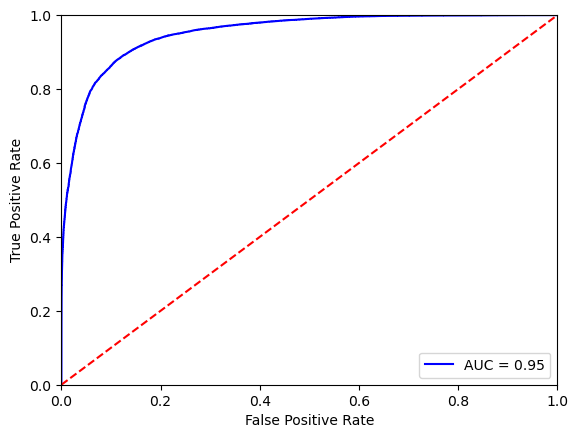

In [82]:
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(labels, positive_preds_probability)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
# plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

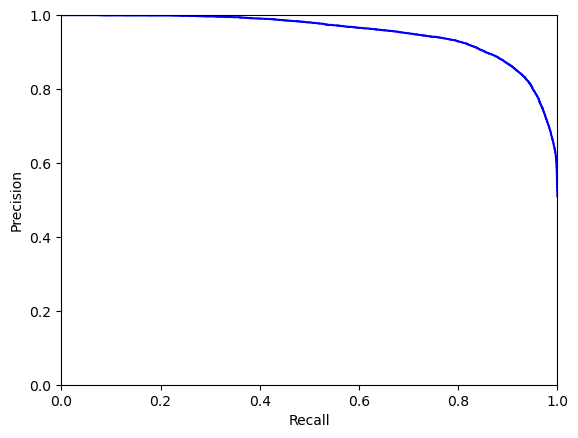

In [81]:
precision, recall, threshold = metrics.precision_recall_curve(labels, positive_preds_probability)

# plt.title('Precision-Recall Curve')
plt.plot(recall, precision, 'b')
plt.ylabel('Precision')
plt.xlabel('Recall')

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.show()

In [58]:
test_df

,file,function_name,arg1,arg2,arg_type,param1,param2,labels
0,cleaned/powerswitch-os/vga.c,outb,mode13[2][i],0x3cf,int,NaN,NaN,1
1,cleaned/platform_external/icu4c/test/cintltst/...,strcmp,subBundleKey,availableFormats,const char *,NaN,NaN,0
2,cleaned/gnushogi/xshogi/xshogi.c,strcmp,name,Yes,const char *,__s1,__s2,0
3,cleaned/asuswrt-merlin/release/src/router/samb...,DEBUG,0,"(""%s: bad validation_level value %d.\n"",fn,(in...",int,NaN,NaN,0
4,cleaned/tos-sfsu-fall2012/kernel/shell.c,is_command,command,pong,char *,s1,s2,0
...,...,...,...,...,...,...,...,...
54055,cleaned/lucy/clownfish/compiler/src/CFCType.c,strcmp,specifier,int64_t,const char *,__s1,__s2,0
54056,cleaned/opensplice/src/services/ddsi2/code/nn_...,avl_delete,"onode_from_node(tree,n)",tree,void *,vtree,vnode,1
54057,cleaned/marss/qemu/hw/etraxfs_pic.c,qemu_set_irq,!!fs->regs[R_R_NMI],fs->parent_nmi,<dependent type>,NaN,NaN,1
54058,cleaned/sane-backends/backend/genesys_gl847.c,SETREG,0x9d,0x06,int,NaN,NaN,0


In [59]:
test_df["predictions"] = preds

In [60]:
test_df

,file,function_name,arg1,arg2,arg_type,param1,param2,labels,predictions
0,cleaned/powerswitch-os/vga.c,outb,mode13[2][i],0x3cf,int,NaN,NaN,1,1
1,cleaned/platform_external/icu4c/test/cintltst/...,strcmp,subBundleKey,availableFormats,const char *,NaN,NaN,0,0
2,cleaned/gnushogi/xshogi/xshogi.c,strcmp,name,Yes,const char *,__s1,__s2,0,0
3,cleaned/asuswrt-merlin/release/src/router/samb...,DEBUG,0,"(""%s: bad validation_level value %d.\n"",fn,(in...",int,NaN,NaN,0,0
4,cleaned/tos-sfsu-fall2012/kernel/shell.c,is_command,command,pong,char *,s1,s2,0,0
...,...,...,...,...,...,...,...,...,...
54055,cleaned/lucy/clownfish/compiler/src/CFCType.c,strcmp,specifier,int64_t,const char *,__s1,__s2,0,0
54056,cleaned/opensplice/src/services/ddsi2/code/nn_...,avl_delete,"onode_from_node(tree,n)",tree,void *,vtree,vnode,1,1
54057,cleaned/marss/qemu/hw/etraxfs_pic.c,qemu_set_irq,!!fs->regs[R_R_NMI],fs->parent_nmi,<dependent type>,NaN,NaN,1,0
54058,cleaned/sane-backends/backend/genesys_gl847.c,SETREG,0x9d,0x06,int,NaN,NaN,0,0


In [61]:
positive_probabilities = softmax(prediction.predictions)[:, 1]
positive_probabilities

array([0.7127268 , 0.04138989, 0.0478017 , ..., 0.01214881, 0.32554984,
       0.00087541], dtype=float32)

In [62]:
test_df["positive_probabilities"] = positive_probabilities
test_df

,file,function_name,arg1,arg2,arg_type,param1,param2,labels,predictions,positive_probabilities
0,cleaned/powerswitch-os/vga.c,outb,mode13[2][i],0x3cf,int,NaN,NaN,1,1,0.712727
1,cleaned/platform_external/icu4c/test/cintltst/...,strcmp,subBundleKey,availableFormats,const char *,NaN,NaN,0,0,0.041390
2,cleaned/gnushogi/xshogi/xshogi.c,strcmp,name,Yes,const char *,__s1,__s2,0,0,0.047802
3,cleaned/asuswrt-merlin/release/src/router/samb...,DEBUG,0,"(""%s: bad validation_level value %d.\n"",fn,(in...",int,NaN,NaN,0,0,0.000150
4,cleaned/tos-sfsu-fall2012/kernel/shell.c,is_command,command,pong,char *,s1,s2,0,0,0.000289
...,...,...,...,...,...,...,...,...,...,...
54055,cleaned/lucy/clownfish/compiler/src/CFCType.c,strcmp,specifier,int64_t,const char *,__s1,__s2,0,0,0.003454
54056,cleaned/opensplice/src/services/ddsi2/code/nn_...,avl_delete,"onode_from_node(tree,n)",tree,void *,vtree,vnode,1,1,0.978509
54057,cleaned/marss/qemu/hw/etraxfs_pic.c,qemu_set_irq,!!fs->regs[R_R_NMI],fs->parent_nmi,<dependent type>,NaN,NaN,1,0,0.012149
54058,cleaned/sane-backends/backend/genesys_gl847.c,SETREG,0x9d,0x06,int,NaN,NaN,0,0,0.325550


In [63]:
test_df.to_csv("function_args_swap_test_dataset_predictions.csv", sep="\t", index=False)